# Submission instructions 

All code that you write should be in this notebook.
Submit:

* This notebook with your code added. Make sure to add enough documentation.
* A short report, max 2 pages including any figures and/or tables (it is likely that you won't need the full 2 pages). Use [this template](https://www.overleaf.com/read/mvskntycrckw). 

For questions, make use of the "Lab" session (see schedule).
Questions can also be posted to the MS teams channel called "Lab". 


# Installing AIF360

In this assignment, we're going to use the AIF360 library.
For documentation, take a look at:

    * https://aif360.mybluemix.net/
    * https://aif360.readthedocs.io/en/latest/ (API documentation)
    * https://github.com/Trusted-AI/AIF360 Installation instructions

We recommend using a dedicated Python environment for this assignment, for example
by using Conda (https://docs.conda.io/en/latest/).
You could also use Google Colab (https://colab.research.google.com/).

When installing AIF360, you only need to install the stable, basic version (e.g., pip install aif360)
You don't need to install the additional optional dependencies.

The library itself provides some examples in the GitHub repository, see:
https://github.com/Trusted-AI/AIF360/tree/master/examples.

**Notes**
* The lines below starting with ! can be used in Google Colab by commenting them out, or in your console
* The first time you're running the import statements, you may get a warning "No module named tensorflow".
  This can be ignored--we don't need it for this assignment. Just run the code block again, and it should disappear

In [ ]:
!pip install aif360
!pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 5.0 MB/s 
     |████████████████████████████████| 564 kB 33.1 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=71150b224b497a2602f57ede00138da636f9de4b7d9629149acf601bb021d323
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 5.0 MB/s 


In [ ]:
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
from aif360.metrics import BinaryLabelDatasetMetric

# Exploring the data

**COMPAS dataset**

In this assignment we're going to use the COMPAS dataset.

If you haven't done so already, take a look at this article: https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing.
For background on the dataset, see https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm.

**Reading in the COMPAS dataset**

The AIF360 library has already built in code to read in this dataset.
However, you'll first need to manually download the COMPAS dataset 
and put it into a specified directory. 
See: https://github.com/Trusted-AI/AIF360/blob/master/aif360/data/raw/compas/README.md.
If you try to load in the dataset for the first time, the library will give you instructions on the steps to download the data.

The protected attributes in this dataset are 'sex' and 'race'. 
For this assignment, we'll only focus on race.

The label codes recidivism, which they defined as a new arrest within 2 years. 
Note that in this dataset, the label is coded with 1 being the favorable label.

In [ ]:
!wget -c https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
# !mv compas-scores-two-years.csv PATH_TO_DATA_FILE
!mv compas-scores-two-years.csv /usr/local/lib/python3.7/dist-packages/aif360/data/raw/compas
# For Google Colab, the DATA_PATH is /usr/local/lib/python3.7/dist-packages/aif360/data/raw/compas

compas_data = load_preproc_data_compas(protected_attributes=['race'])

--2022-05-24 12:21:37--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘compas-scores-two-years.csv’

compas-scores-two-y 100%[===================>]   2.43M  --.-KB/s    in 0.06s   

2022-05-24 12:21:38 (37.6 MB/s) - ‘compas-scores-two-years.csv’ saved [2546489/2546489]



Now let's take a look at the data:

In [ ]:
compas_data

               instance weights features                                       \
                                         protected attribute                    
                                     sex                race age_cat=25 to 45   
instance names                                                                  
3                           1.0      0.0                 0.0              1.0   
4                           1.0      0.0                 0.0              0.0   
8                           1.0      0.0                 1.0              1.0   
10                          1.0      1.0                 1.0              1.0   
14                          1.0      0.0                 1.0              1.0   
...                         ...      ...                 ...              ...   
10994                       1.0      0.0                 0.0              1.0   
10995                       1.0      0.0                 0.0              0.0   
10996                       

**Creating a train and test split**

We'll create a train (80%) and test split (20%). 

Note: *Usually when carrying out machine learning experiments,
we also need a dev set for developing and selecting our models (incl. tuning of hyper-parameters).
However, in this assignment, the goal is not to optimize 
the performance of models so we'll only use a train and test split.*

Note: *due to random division of train/test sets, the actual output in your runs may slightly differ with statistics showing in the rest of this notebook.*

In [ ]:
train_data, test_data = compas_data.split([0.8], shuffle=True)

We would also like to know what outcome is favorable in our dataset (because no Recidivism is preferable, it is ```two_year_recid=0``` in our case).

In [ ]:
fav_idx = int(train_data.favorable_label)
print(fav_idx)

0


In this assignment, we'll focus on protected attribute: race.
This is coded as a binary variable with "Caucasian" coded as 1 and "African-American" coded as 0.

In [ ]:
priv_group   = [{'race': 1}]  # Caucasian
unpriv_group = [{'race': 0}]  # African-American

Now let's look at some statistics:

In [ ]:
print("Training set shape: %s, %s" % train_data.features.shape)
print("Favorable (not recid) and unfavorable (recid) labels: %s; %s" % (train_data.favorable_label, train_data.unfavorable_label))
print("Protected attribute names: %s" % train_data.protected_attribute_names)
# labels of privileged (1) and unprovileged groups (0)
print("Privileged (Caucasian) and unprivileged (African-American) protected attribute values: %s, %s" % (train_data.privileged_protected_attributes, 
      train_data.unprivileged_protected_attributes))
print("Feature names: %s" % train_data.feature_names)

Training set shape: 4222, 10
Favorable (not recid) and unfavorable (recid) labels: 0.0; 1.0
Protected attribute names: ['race']
Privileged (Caucasian) and unprivileged (African-American) protected attribute values: [array([1.])], [array([0.])]
Feature names: ['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


In [ ]:
print("Test set shape: %s, %s" % test_data.features.shape)

Test set shape: 1056, 10


Now, let's take a look at the test data and compute the following difference:

$$𝑃(𝑌=favorable|𝐷=unprivileged)−𝑃(𝑌=favorable|𝐷=privileged)$$


In [ ]:
metric_test_data = BinaryLabelDatasetMetric(test_data, 
                             unprivileged_groups = unpriv_group,
                             privileged_groups   = priv_group)
print("Mean difference (statistical parity difference) = %f" % 
      metric_test_data.statistical_parity_difference())


Mean difference (statistical parity difference) = -0.099688


In [ ]:
metric_train_data = BinaryLabelDatasetMetric(train_data, 
                             unprivileged_groups = unpriv_group,
                             privileged_groups   = priv_group)
print("Mean difference (statistical parity difference) = %f" % 
      metric_train_data.statistical_parity_difference())

Mean difference (statistical parity difference) = -0.140265


To be clear, because we're looking at the original label distribution this is the base rate difference between the two groups

In [ ]:
metric_test_data.base_rate(False)  # Base rate of the unprivileged group

0.47900466562986005

In [ ]:
metric_test_data.base_rate(True)   # Base rate of the privileged group

0.5786924939467313

In [ ]:
metric_train_data.base_rate(False)  # Base rate of the unprivileged group

0.476303317535545

In [ ]:
metric_train_data.base_rate(True)   # Base rate of the privileged group

0.6165680473372781

To explore the data, it can also help to convert it to a dataframe.
Note that here the favorable label is no recidivism (two_year_recid=0), 
while the mean values are calculated according to two_year_recid=1.
Therefore, we get the results as (1 - base rate).

In [ ]:
test_data.convert_to_dataframe()[0].groupby(['race'])['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
0.0,643.0,0.520995,0.499948,0.0,0.0,1.0,1.0,1.0
1.0,413.0,0.421308,0.494368,0.0,0.0,0.0,1.0,1.0


**Report**

Report basic statistics in your report, such as the size of the training and test set.

Now let's explore the *training* data further.
In your report include a short analysis of the training data. Look at the base rates of the outcome variable (two year recidivism) for the combination of both race and sex categories. What do you see?

In [ ]:
train_data.convert_to_dataframe()[0].groupby(['race'])['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
0.0,2532.0,0.523697,0.499537,0.0,0.0,1.0,1.0,1.0
1.0,1690.0,0.383432,0.486366,0.0,0.0,0.0,1.0,1.0


In [ ]:
train_data.convert_to_dataframe()[0].groupby(['sex'])['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
0.0,3404.0,0.492656,0.500020,0.0,0.0,0.0,1.0,1.0
1.0,818.0,0.363081,0.481182,0.0,0.0,0.0,1.0,1.0


In [ ]:
train_data.convert_to_dataframe()[0].groupby(['race', 'sex'])['two_year_recid'].describe()

count      mean       std  min  25%  50%  75%  max
race sex                                                     
0.0  0.0  2096.0  0.554389  0.497152  0.0  0.0  1.0  1.0  1.0
     1.0   436.0  0.376147  0.484974  0.0  0.0  0.0  1.0  1.0
1.0  0.0  1308.0  0.393731  0.488763  0.0  0.0  0.0  1.0  1.0
     1.0   382.0  0.348168  0.477014  0.0  0.0  0.0  1.0  1.0

In [ ]:
test_data.convert_to_dataframe()[0].groupby(['race'])['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
0.0,643.0,0.520995,0.499948,0.0,0.0,1.0,1.0,1.0
1.0,413.0,0.421308,0.494368,0.0,0.0,0.0,1.0,1.0


In [ ]:
test_data.convert_to_dataframe()[0].groupby(['sex'])['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
0.0,843.0,0.513642,0.500111,0.0,0.0,1.0,1.0,1.0
1.0,213.0,0.356808,0.480186,0.0,0.0,0.0,1.0,1.0


In [ ]:
test_data.convert_to_dataframe()[0].groupby(['race', 'sex'])['two_year_recid'].describe()

count      mean       std  min  25%  50%  75%  max
race sex                                                    
0.0  0.0  530.0  0.558491  0.497036  0.0  0.0  1.0  1.0  1.0
     1.0  113.0  0.345133  0.477529  0.0  0.0  0.0  1.0  1.0
1.0  0.0  313.0  0.437700  0.496898  0.0  0.0  0.0  1.0  1.0
     1.0  100.0  0.370000  0.485237  0.0  0.0  0.0  1.0  1.0

# Classifiers

**Training classifiers**

Now, train the following classifiers:

1. A logistic regression classifier making use of all features 
2. A logistic regression classifier without the race feature
3. A classifier after reweighting instances in the training set https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.Reweighing.html.
    * Report the weights that are used for reweighing and a short interpretation/discussion.
    * Hint: Think about when you should reweight the data: during initialization or during training (i.e. fit)? Read the documentation of the Logistic regression model in Scikit-learn carefully (if you use it). 
4. A classifier after post-processing 
https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.postprocessing.EqOddsPostprocessing.html#aif360.algorithms.postprocessing.EqOddsPostprocessing 

For training the classifier we recommend using scikit-learn (https://scikit-learn.org/stable/).
AIF360 contains a sklearn wrapper, however that one is in development and not complete.
We recommend using the base AIF360 library, and not their sklearn wrapper.

**Report**

For each of these classifiers, report the following:
* Overall precision, recall, F1 and accuracy.
* The statistical parity difference. Does this classifier satisfy statistical parity? How does this difference compare to the original dataset?
* Difference of true positive rates between the two groups. Does the classifier satisfy the equal opportunity criterion? 



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from aif360.datasets.binary_label_dataset import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
import pandas as pd
# A logistic regression classifier making use of all features
train_data_new = train_data.convert_to_dataframe()[0]
train_data_x = train_data_new.drop(labels = "two_year_recid", axis = 1)
train_data_y = train_data_new["two_year_recid"]
Classifier_1 = LogisticRegression().fit(train_data_x, train_data_y)

test_data_new = test_data.convert_to_dataframe()[0]
test_data_x = test_data_new.drop(labels = "two_year_recid", axis = 1)
test_data_y = test_data_new["two_year_recid"]
Pred_1 = Classifier_1.predict(test_data_x)

precision_1 = precision_score(test_data_y, Pred_1)
recall_1 = recall_score(test_data_y, Pred_1)
F1_1 = f1_score(test_data_y, Pred_1)
accuracy_1 = accuracy_score(test_data_y, Pred_1)
print("The precision of the first classifier is: ", precision_1)
print("The recall of the first classifier is: ", recall_1)
print("The F1 score of the first classifier is: ", F1_1)
print("The accuracy of the first classifier is: ", accuracy_1)

temp = test_data_new.copy()
temp["two_year_recid"] = Pred_1
labeled_data = BinaryLabelDataset(df = temp, label_names = ["two_year_recid"], protected_attribute_names = ["race"], favorable_label = 0, unfavorable_label = 1)
metric_test_data = BinaryLabelDatasetMetric(labeled_data, unpriv_group, priv_group)
parity_difference = metric_test_data.statistical_parity_difference()
print("The mean difference (statistical parity difference) of the first classifier is:", parity_difference)

labeled_data = BinaryLabelDataset(df = test_data_new, label_names = ["two_year_recid"], protected_attribute_names = ["race"], favorable_label = 0, unfavorable_label = 1)
labeled_data_1 = labeled_data.copy()
labeled_data_2 = labeled_data.copy()
labeled_data_2.labels = Pred_1.reshape(-1, 1)
metric_test_data = ClassificationMetric(labeled_data_1, labeled_data_2, unpriv_group, priv_group,)
true_positive_rate_difference = metric_test_data.true_positive_rate_difference()
true_positive_rate_priviledged = metric_test_data.true_positive_rate(True)
true_positive_rate_unpriviledged = metric_test_data.true_positive_rate(False)
print("The true positive rate difference of the first classifier is:", true_positive_rate_difference)
print("The true positive rate priviledged of the first classifier is:", true_positive_rate_priviledged)
print("The true positive rate unpriviledged of the first classifier is:", true_positive_rate_unpriviledged)

The precision of the first classifier is:  0.6623655913978495
The recall of the first classifier is:  0.6051080550098232
The F1 score of the first classifier is:  0.6324435318275154
The accuracy of the first classifier is:  0.6609848484848485
The mean difference (statistical parity difference) of the first classifier is: -0.2976852601493453
The true positive rate difference of the first classifier is: -0.2793837961201978
The true positive rate priviledged of the first classifier is: 0.8702928870292888
The true positive rate unpriviledged of the first classifier is: 0.5909090909090909


In [ ]:
# A logistic regression classifier without the race feature
#train_data_new = train_data.convert_to_dataframe()[0]
train_data_x = train_data_new.drop(labels = ["two_year_recid", "race"], axis = 1)
train_data_y = train_data_new["two_year_recid"]
Classifier_2 = LogisticRegression().fit(train_data_x, train_data_y)

#test_data_new = test_data.convert_to_dataframe()[0]
test_data_x = test_data_new.drop(labels = ["two_year_recid", "race"], axis = 1)
test_data_y = test_data_new["two_year_recid"]
Pred_2 = Classifier_2.predict(test_data_x)

precision_2 = precision_score(test_data_y, Pred_2)
recall_2 = recall_score(test_data_y, Pred_2)
F1_2 = f1_score(test_data_y, Pred_2)
accuracy_2 = accuracy_score(test_data_y, Pred_2)
print("The precision of the second classifier is: ", precision_2)
print("The recall of the second classifier is: ", recall_2)
print("The F1 score of the second classifier is: ", F1_2)
print("The accuracy of the second classifier is: ", accuracy_2)

#temp_2 = test_data_new.copy()
temp["two_year_recid"] = Pred_2
labeled_data = BinaryLabelDataset(df = temp, label_names = ["two_year_recid"], protected_attribute_names = ["race"], favorable_label = 0, unfavorable_label = 1)
metric_test_data = BinaryLabelDatasetMetric(labeled_data, unpriv_group, priv_group)
parity_difference = metric_test_data.statistical_parity_difference()
print("The mean difference (statistical parity difference) of the second classifier is:", parity_difference)

labeled_data = BinaryLabelDataset(df = test_data_new, label_names = ["two_year_recid"], protected_attribute_names = ["race"], favorable_label = 0, unfavorable_label = 1)
labeled_data_1 = labeled_data.copy()
labeled_data_2 = labeled_data.copy()
labeled_data_2.labels = Pred_2.reshape(-1, 1)
metric_test_data = ClassificationMetric(labeled_data_1, labeled_data_2, unpriv_group, priv_group,)
true_positive_rate_difference = metric_test_data.true_positive_rate_difference()
true_positive_rate_priviledged = metric_test_data.true_positive_rate(True)
true_positive_rate_unpriviledged = metric_test_data.true_positive_rate(False)
print("The true positive rate difference of the second classifier is:", true_positive_rate_difference)
print("The true positive rate priviledged of the second classifier is:", true_positive_rate_priviledged)
print("The true positive rate unpriviledged of the second classifier is:", true_positive_rate_unpriviledged)

The precision of the second classifier is:  0.6828087167070218
The recall of the second classifier is:  0.5540275049115914
The F1 score of the second classifier is:  0.6117136659436009
The accuracy of the second classifier is:  0.6609848484848485
The mean difference (statistical parity difference) of the second classifier is: -0.21283782511607596
The true positive rate difference of the second classifier is: -0.18753735803945004
The true positive rate priviledged of the second classifier is: 0.8661087866108786
The true positive rate unpriviledged of the second classifier is: 0.6785714285714286


The value of the weights of the train data:  [1. 1. 1. ... 1. 1. 1.]
The mean value of the weights of the train data:  1.0
The standard error value of the weights of the train data:  0.0
The value of the weights of the transformed data:  [1.11787816 1.11787816 0.89278955 ... 0.86356904 0.89278955 0.89278955]
The mean value of the weights of the transformed data:  1.0
The standard error value of the weights of the transformed data:  0.13985673014786515


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


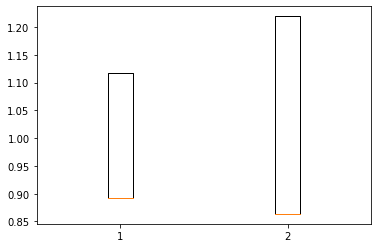

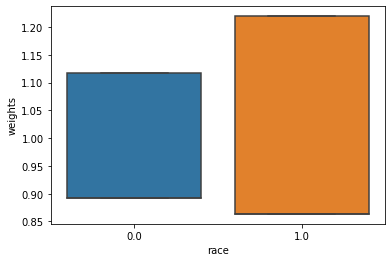

In [ ]:
from aif360.algorithms.preprocessing import Reweighing
import matplotlib.pyplot as plt
import seaborn as sns
ReWeight = Reweighing(unpriv_group, priv_group).fit(train_data)
train_data_transformed = ReWeight.transform(train_data)
print("The value of the weights of the train data: ", train_data.instance_weights)
print("The mean value of the weights of the train data: ", train_data.instance_weights.mean())
print("The standard error value of the weights of the train data: ", train_data.instance_weights.std())

print("The value of the weights of the transformed data: ", train_data_transformed.instance_weights)
print("The mean value of the weights of the transformed data: ", train_data_transformed.instance_weights.mean())
print("The standard error value of the weights of the transformed data: ", train_data_transformed.instance_weights.std())

train_data_new = train_data.convert_to_dataframe()[0]
train_data_new["weights"] = train_data_transformed.instance_weights
plt.boxplot([train_data_new[train_data_new.race == 0.0]["weights"], train_data_new[train_data_new.race == 1.0]["weights"]])
plt.show()
sns.boxplot(x = train_data_new["race"], y = train_data_new["weights"])
plt.show()


In [ ]:
train_data_new.groupby(['race'])['weights'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
0.0,2532.0,1.0,0.112440,0.892790,0.892790,0.892790,1.117878,1.117878
1.0,1690.0,1.0,0.173056,0.863569,0.863569,0.863569,1.219384,1.219384


In [ ]:
# A logistic regression classifier after reweighting instances making use of all features
train_data_new = train_data.convert_to_dataframe()[0]
train_data_x = train_data_new.drop(labels = "two_year_recid", axis = 1)
train_data_y = train_data_new["two_year_recid"]
Classifier_3 = LogisticRegression().fit(train_data_x, train_data_y, sample_weight = train_data_transformed.instance_weights)

test_data_new = test_data.convert_to_dataframe()[0]
test_data_x = test_data_new.drop(labels = "two_year_recid", axis = 1)
test_data_y = test_data_new["two_year_recid"]
Pred_3 = Classifier_3.predict(test_data_x)

precision_3 = precision_score(test_data_y, Pred_3)
recall_3 = recall_score(test_data_y, Pred_3)
F1_3 = f1_score(test_data_y, Pred_3)
accuracy_3 = accuracy_score(test_data_y, Pred_3)
print("The precision of the third classifier is: ", precision_3)
print("The recall of the third classifier is: ", recall_3)
print("The F1 score of the third classifier is: ", F1_3)
print("The accuracy of the third classifier is: ", accuracy_3)

temp = test_data_new.copy()
temp["two_year_recid"] = Pred_3
labeled_data = BinaryLabelDataset(df = temp, label_names = ["two_year_recid"], protected_attribute_names = ["race"], favorable_label = 0, unfavorable_label = 1)
metric_test_data = BinaryLabelDatasetMetric(labeled_data, unpriv_group, priv_group)
parity_difference = metric_test_data.statistical_parity_difference()
print("The mean difference (statistical parity difference) of the third classifier is:", parity_difference)

labeled_data = BinaryLabelDataset(df = test_data_new, label_names = ["two_year_recid"], protected_attribute_names = ["race"], favorable_label = 0, unfavorable_label = 1)
labeled_data_1 = labeled_data.copy()
labeled_data_2 = labeled_data.copy()
labeled_data_2.labels = Pred_3.reshape(-1, 1)
metric_test_data = ClassificationMetric(labeled_data_1, labeled_data_2, unpriv_group, priv_group,)
true_positive_rate_difference = metric_test_data.true_positive_rate_difference()
true_positive_rate_priviledged = metric_test_data.true_positive_rate(True)
true_positive_rate_unpriviledged = metric_test_data.true_positive_rate(False)
print("The true positive rate difference of the third classifier is:", true_positive_rate_difference)
print("The true positive rate priviledged of the third classifier is:", true_positive_rate_priviledged)
print("The true positive rate unpriviledged of the third classifier is:", true_positive_rate_unpriviledged)

The precision of the third classifier is:  0.6450939457202505
The recall of the third classifier is:  0.6070726915520629
The F1 score of the third classifier is:  0.6255060728744939
The accuracy of the third classifier is:  0.6496212121212122
The mean difference (statistical parity difference) of the third classifier is: -0.045078494797766266
The true positive rate difference of the third classifier is: -0.009495734391131938
The true positive rate priviledged of the third classifier is: 0.694560669456067
The true positive rate unpriviledged of the third classifier is: 0.685064935064935


In [ ]:
# A logistic regression classifier after reweighting instances without the race feature
ReWeight = Reweighing(unpriv_group, priv_group).fit(train_data)
train_data_transformed = ReWeight.transform(train_data)

train_data_new = train_data.convert_to_dataframe()[0]
train_data_x = train_data_new.drop(labels = ["two_year_recid", "race"], axis = 1)
train_data_y = train_data_new["two_year_recid"]
Classifier_4 = LogisticRegression().fit(train_data_x, train_data_y, sample_weight = train_data_transformed.instance_weights)

test_data_new = test_data.convert_to_dataframe()[0]
test_data_x = test_data_new.drop(labels = ["two_year_recid", "race"], axis = 1)
test_data_y = test_data_new["two_year_recid"]
Pred_4 = Classifier_4.predict(test_data_x)

precision_4 = precision_score(test_data_y, Pred_4)
recall_4 = recall_score(test_data_y, Pred_4)
F1_4 = f1_score(test_data_y, Pred_4)
accuracy_4 = accuracy_score(test_data_y, Pred_4)
print("The precision of the fourth classifier is: ", precision_4)
print("The recall of the fourth classifier is: ", recall_4)
print("The F1 score of the fourth classifier is: ", F1_4)
print("The accuracy of the fourth classifier is: ", accuracy_4)

temp = test_data_new.copy()
temp["two_year_recid"] = Pred_4
labeled_data = BinaryLabelDataset(df = temp, label_names = ["two_year_recid"], protected_attribute_names = ["race"], favorable_label = 0, unfavorable_label = 1)
metric_test_data = BinaryLabelDatasetMetric(labeled_data, unpriv_group, priv_group)
parity_difference = metric_test_data.statistical_parity_difference()
print("The mean difference (statistical parity difference) of the fourth classifier is:", parity_difference)

labeled_data = BinaryLabelDataset(df = test_data_new, label_names = ["two_year_recid"], protected_attribute_names = ["race"], favorable_label = 0, unfavorable_label = 1)
labeled_data_1 = labeled_data.copy()
labeled_data_2 = labeled_data.copy()
labeled_data_2.labels = Pred_4.reshape(-1, 1)
metric_test_data = ClassificationMetric(labeled_data_1, labeled_data_2, unpriv_group, priv_group,)
true_positive_rate_difference = metric_test_data.true_positive_rate_difference()
true_positive_rate_priviledged = metric_test_data.true_positive_rate(True)
true_positive_rate_unpriviledged = metric_test_data.true_positive_rate(False)
print("The true positive rate difference of the fourth classifier is:", true_positive_rate_difference)
print("The true positive rate priviledged of the fourth classifier is:", true_positive_rate_priviledged)
print("The true positive rate unpriviledged of the fourth classifier is:", true_positive_rate_unpriviledged)

The precision of the fourth classifier is:  0.6842105263157895
The recall of the fourth classifier is:  0.587426326129666
The F1 score of the fourth classifier is:  0.6321353065539113
The accuracy of the fourth classifier is:  0.6704545454545454
The mean difference (statistical parity difference) of the fourth classifier is: -0.22232724178054591
The true positive rate difference of the fourth classifier is: -0.1954029234363962
The true positive rate priviledged of the fourth classifier is: 0.8577405857740585
The true positive rate unpriviledged of the fourth classifier is: 0.6623376623376623


In [ ]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing
import numpy as np

train_data_new = train_data.convert_to_dataframe()[0]
train_data_x = train_data_new.drop(labels = ["two_year_recid", "race"], axis = 1)
train_data_y = train_data_new["two_year_recid"]
Classifier_5 = LogisticRegression().fit(train_data_x, train_data_y)

test_data_new = test_data.convert_to_dataframe()[0]
test_data_x = test_data_new.drop(labels = ["two_year_recid", "race"], axis = 1)
test_data_y = test_data_new["two_year_recid"]
Pred_5 = Classifier_5.predict(test_data_x)
test_data_true = test_data.copy()
test_data_pred = test_data.copy()
test_data_pred.labels = Pred_5.reshape(-1, 1)


Post_tools = EqOddsPostprocessing(unpriv_group, priv_group).fit(test_data_true, test_data_pred)
test_data_pred_new = Post_tools.predict(test_data_pred)
label_1 = test_data_true.labels
label_2 = test_data_pred_new.labels

precision_5 = precision_score(label_1, label_2)
recall_5 = recall_score(label_1, label_2)
F1_5 = f1_score(label_1, label_2)
accuracy_5 = accuracy_score(label_1, label_2)

print("The precision of the fifth classifier is: ", precision_5)
print("The recall of the fifth classifier is: ", recall_5)
print("The F1 score of the fifth classifier is: ", F1_5)
print("The accuracy of the fifth classifier is: ", accuracy_5)

metric_test_data = BinaryLabelDatasetMetric(test_data_pred_new, unpriv_group, priv_group)
parity_difference = metric_test_data.statistical_parity_difference()
print("The mean difference (statistical parity difference) of the fourth classifier is:", parity_difference)

labeled_data_1 = test_data_pred.copy()
labeled_data_2 = test_data_pred.copy()
labeled_data_2.labels = test_data_pred_new.labels.reshape(-1, 1)
metric_test_data = ClassificationMetric(labeled_data_1, labeled_data_2, unpriv_group, priv_group,)
true_positive_rate_difference = metric_test_data.true_positive_rate_difference()
true_positive_rate_priviledged = metric_test_data.true_positive_rate(True)
true_positive_rate_unpriviledged = metric_test_data.true_positive_rate(False)
print("The true positive rate difference of the fourth classifier is:", true_positive_rate_difference)
print("The true positive rate priviledged of the fourth classifier is:", true_positive_rate_priviledged)
print("The true positive rate unpriviledged of the fourth classifier is:", true_positive_rate_unpriviledged)

The precision of the fifth classifier is:  0.6437054631828979
The recall of the fifth classifier is:  0.5324165029469549
The F1 score of the fifth classifier is:  0.5827956989247313
The accuracy of the fifth classifier is:  0.6325757575757576
The mean difference (statistical parity difference) of the fourth classifier is: -0.026453631772976993
The true positive rate difference of the fourth classifier is: 0.16393442622950816
The true positive rate priviledged of the fourth classifier is: 0.8360655737704918
The true positive rate unpriviledged of the fourth classifier is: 1.0


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


# Discussion

**Report**
* Shortly discuss your results. For example, how do the different classifiers compare against each other? 
* Also include a short ethical discussion (1 or 2 paragraphs) reflecting on these two aspects: 1) The use of a ML system to try to predict recidivism; 2) The public release of a dataset like this.
